In [1]:
import sys
import os
sys.path.append('..')
sys.path.append('../failure_directions')
import torch
import torchvision
import failure_directions
import numpy as np
import torchvision.transforms as transforms
from torch.cuda.amp import autocast
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt


import failure_directions.src.svm_utils as svm_utils
import failure_directions.src.visualization_utils as viz_utils
import failure_directions.src.ds_utils as ds_utils
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from failure_directions.src.label_maps import CLASS_DICT
import pickle as pkl
from torchvision.datasets.folder import pil_loader
import failure_directions.src.pytorch_datasets as pytorch_dataset


/mnt/cfs/home/saachij/conda_envs/ffcv_cfs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set()
BLUE = sns.color_palette("tab10")[0]
RED = sns.color_palette("tab10")[3]
ORANGE = sns.color_palette("tab10")[1]
BROWN = sns.color_palette("tab10")[5]
GRAY = sns.color_palette("tab10")[7]
GREEN = sns.color_palette("tab10")[2]

import matplotlib.pylab as pylab
params = {'legend.fontsize': 12,
          'figure.figsize': (5, 3),
         'axes.labelsize': 14,
         'axes.titlesize':16,
         'xtick.labelsize':14,
         'ytick.labelsize':14}
pylab.rcParams.update(params)


In [3]:
#Load SVM Model
beton_root = "/mnt/cfs/projects/correlated_errors/betons"
experiment_root = "/mnt/cfs/projects/correlated_errors/experiments/spurious_cifar100/unlabeled_1_4_new_spurious_norm"

svm_name = "svm_spurious_unlabeled_normalized"
name = os.path.join(experiment_root, f"svm_checkpoints/{svm_name}.pt") # SVM output file
svm_model_name = os.path.join(experiment_root, f"svm_checkpoints/{svm_name}_model.pkl") # SVM output file
model_root = os.path.join(experiment_root, "models")
model_ckpt = os.path.join(model_root, "spurious_supercifar100_unlabeled/version_0/checkpoints/checkpoint_last.pt")
loss_upweight_root = os.path.join(experiment_root, "loss_vec_files")
subset_root = os.path.join(experiment_root, "subset_index_files")

%cd ../failure_directions
processor = viz_utils.SVMProcessor(name, root=beton_root, checkpoint_path=model_ckpt, get_unlabeled=True)
classes_to_drop = torch.load(processor.metrics['args']['indices_file'])['classes_to_drop']
%cd ../analysis_nbs
svm_model = processor._build_model(model_ckpt)


/mnt/cfs/home/saachij/src/failure-directions/failure_directions
-----------train_metrics--------------
{'Confusion Matrix': array([[   41,    34],
       [ 6135, 10806]]),
 'Model Accuracy': 0.9955923836389281,
 'SVM Accuracy': 0.637458860874176,
 'SVM Balanced Accuracy': 0.5922637581825256}
-----------val_metrics--------------
{'Confusion Matrix': array([[2532,  528],
       [1286, 5654]]),
 'Model Accuracy': 0.694,
 'SVM Accuracy': 0.8185999989509583,
 'SVM Balanced Accuracy': 0.8210741877555847}
-----------test_metrics--------------
{'Confusion Matrix': array([[2058,  979],
       [1748, 5215]]),
 'Model Accuracy': 0.6963,
 'SVM Accuracy': 0.7272999882698059,
 'SVM Balanced Accuracy': 0.7133005857467651}
-----------unlabeled_metrics--------------
{'Confusion Matrix': array([[ 4157,  2068],
       [ 3495, 10280]]),
 'Model Accuracy': 0.68875,
 'SVM Accuracy': 0.7218499779701233,
 'SVM Balanced Accuracy': 0.7070353329181671}
Using default os_cache: False
Using default quasi_random: Tr

100%|██████████| 171/171 [00:03<00:00, 46.67it/s] 


Accuracy 0.9947108626365662


100%|██████████| 100/100 [00:01<00:00, 83.16it/s]


Accuracy 0.6940000057220459


100%|██████████| 100/100 [00:01<00:00, 62.66it/s]


Accuracy 0.6963000297546387


100%|██████████| 200/200 [00:01<00:00, 124.60it/s]


Accuracy 0.6887500286102295
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs
{'training_args': {'epochs': 35, 'lr': 0.5, 'optimizer': {'momentum': 0.9, 'weight_decay': 0.0005}, 'lr_scheduler': {'type': 'cyclic', 'lr_peak_epoch': 5}, 'iters_per_epoch': 33}, 'epoch': 34, 'training_metrics': {'loss': 0.029270435203657005, 'acc': 0.9939630681818182}, 'val_metrics': {'loss': 1.3071045623779296, 'acc': 0.6939999999046326}}


In [4]:
import src.pytorch_datasets as pytorch_datasets
ds = pytorch_datasets.SuperCIFAR100(root="/mnt/nfs/home/saachij/datasets/cifar100", train=False)
class_names = np.array(ds.classes)
subclass_names = []
# asterisk subclass_names
for c, n in enumerate(ds.subclasses):
    name = ' '.join(n.split('_'))
    if c in classes_to_drop:
        name += "*"
    subclass_names.append(name)
subclass_names = np.array(subclass_names)
singular_class_names = ['aquatic mammal', 'fish', 'flower', 'food container', 'fruit or vegetable', 'household electrical device', 'household furniture', 'insect', 'large carnivore', 'large man-made outdoor thing', 'large natural outdoor scene', 'large omnivores and herbivore', 'medium-sized mammal', 'non-insect invertebrate', 'person', 'reptile', 'small mammal', 'tree', 'standard vehicle', 'specialized vehicle']

In [5]:
split = 'test'
test_dv = processor.metrics[f'{split}_metrics']['decision_values']
test_confs = processor.run_dict[split]['confs']
test_superclass = processor.metrics[f'{split}_metrics']['classes'] # 0 if female, 1 if male
test_subclass = processor.metrics[f'{split}_metrics']['spuriouses'] #1 if blond, 2 if black hair, 0 if neither
test_problematic = np.in1d(test_subclass, classes_to_drop)
test_pred_correct = processor.metrics[f'{split}_metrics']['ypred']
test_correct = processor.metrics[f'{split}_metrics']['ytrue']

In [6]:
from failure_directions.src.config_parsing import ffcv_read_check_override_config
import yaml
hparams = processor.hparams
%cd ../failure_directions
with open(processor.metrics['args']['config'], 'r') as file:
    fresh_hparams = yaml.safe_load(file)
fresh_hparams = ffcv_read_check_override_config(fresh_hparams)
%cd ../analysis_nbs


/mnt/cfs/home/saachij/src/failure-directions/failure_directions
Using default os_cache: False
Using default quasi_random: True
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default val_beton: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False
Using default cmnist: False
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs


## Get SVM Directions

In [9]:
# Get big CLIP features
clip_processor = failure_directions.CLIPProcessor(ds_mean=hparams['mean'], ds_std=hparams['std'], arch='ViT-L/14')
clip_features = {}
for split, loader in processor.loaders.items():
    clip_features[split] = clip_processor.evaluate_clip_images(loader)

100%|██████████| 200/200 [01:04<00:00,  3.09it/s]


In [10]:
svm_fitter = failure_directions.SVMFitter()
svm_fitter.set_preprocess()
val_gts, val_preds = processor.run_dict['val']['ys'], processor.run_dict['val']['preds']
cv_scores = svm_fitter.fit(preds=val_preds, ys=val_gts, latents=clip_features['val'])

/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)


No whitening


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


In [11]:
import os
directory = "cifar100_large_directions"
os.makedirs(directory, exist_ok=True)
for i in range(len(svm_fitter.clfs)):
    d = svm_fitter.clfs[i].coef_.squeeze(0)
    np.save(f"{directory}/dir{i}.npy", d/np.linalg.norm(d))

In [12]:
from failure_directions.src.clip_utils import get_caption_set
captions = failure_directions.get_caption_set('CIFAR100')
ref_captions = clip_processor.evaluate_clip_captions(captions['reference'])
np.save(f"{directory}/ref_captions.npy", ref_captions.numpy())

100%|██████████| 21/21 [00:00<00:00, 60536.35it/s]


aquatic mammal
fish
flower
food container
fruit or vegetable
household electrical device
household furniture
insect
large carnivore
large man-made outdoor thing
large natural outdoor scene
large omnivores and herbivore
medium-sized mammal
non-insect invertebrate
person
reptile
small mammal
tree
standard vehicle
specialized vehicle
reference


100%|██████████| 1/1 [00:00<00:00, 80.45it/s]


In [13]:
subclass_names

array(['apple', 'aquarium fish', 'baby*', 'bear*', 'beaver*', 'bed',
       'bee', 'beetle', 'bicycle', 'bottle', 'bowl*', 'boy', 'bridge*',
       'bus*', 'butterfly', 'camel', 'can', 'castle', 'caterpillar*',
       'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach',
       'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin',
       'elephant', 'flatfish', 'forest*', 'fox', 'girl', 'hamster',
       'house', 'kangaroo*', 'keyboard', 'lamp*', 'lawn mower', 'leopard',
       'lion', 'lizard*', 'lobster*', 'man', 'maple tree', 'motorcycle',
       'mountain', 'mouse', 'mushroom*', 'oak tree', 'orange', 'orchid*',
       'otter', 'palm tree', 'pear', 'pickup truck', 'pine tree', 'plain',
       'plate', 'poppy', 'porcupine', 'possum*', 'rabbit', 'raccoon',
       'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark*', 'shrew',
       'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel*',
       'streetcar*', 'sunflower', 'sweet pepper', 'table*', 'tank',
   

## Read the generated images

In [8]:
import src.stable_diffusion_utils as sd_utils
from src.stable_diffusion_utils import DiffDataset

images_path = "/mnt/cfs/home/saachij/src/stable-diffusion/cifar100_images"
path_dict = sd_utils.get_path_dict(images_path, num_classes=20)



In [9]:
import torchvision.transforms as transforms
import torchvision
from failure_directions.src.decoders_and_transforms import PyTranslate, PyCutOut
hparams = processor.hparams

fill_color = tuple(map(int, hparams['mean']))

base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=np.array(hparams['mean'])/255, std=np.array(hparams['std'])/255)])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    PyTranslate(2),
    PyCutOut(4, fill_color),
    base_transform
])

# For visualization
INV_NORM = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [255/x for x in hparams['std']]),
                                transforms.Normalize(mean = [-x /255 for x in hparams['mean']],
                                                     std = [ 1., 1., 1. ])])
TOIMAGE = transforms.Compose([INV_NORM, transforms.ToPILImage()])
resize_base_transform = transforms.Compose([base_transform, transforms.Resize((32, 32))])
resize_train_transform = transforms.Compose([train_transform, transforms.Resize((32, 32))])

In [10]:
def evaluate_model(model, loader):
    with torch.no_grad():
        with autocast():
            gts, preds, confs = [], [], []
            for x, y in tqdm(loader):
                x = x.cuda()
                logits = model(x)
                gts.append(y.cpu())
                preds.append(logits.argmax(-1).cpu())
                softmax_logits = nn.Softmax(dim=-1)(logits)
                confs.append(softmax_logits[torch.arange(logits.shape[0]), y].cpu())
    gts = torch.cat(gts)
    preds = torch.cat(preds)
    confs = torch.cat(confs)
    return gts, preds, confs

100%|██████████| 23/23 [00:01<00:00, 20.85it/s]


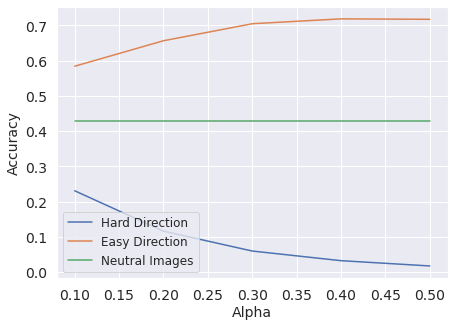

100%|██████████| 24/24 [00:01<00:00, 19.79it/s]


0 0.8290598392486572 0.606


100%|██████████| 24/24 [00:01<00:00, 20.78it/s]


1 0.017094017937779427 0.67


100%|██████████| 24/24 [00:01<00:00, 21.03it/s]


2 0.811965823173523 0.85


100%|██████████| 24/24 [00:01<00:00, 21.30it/s]


3 0.4871794879436493 0.698


100%|██████████| 24/24 [00:01<00:00, 21.20it/s]


4 0.4615384638309479 0.73


100%|██████████| 24/24 [00:01<00:00, 20.82it/s]


5 0.10256410390138626 0.602


100%|██████████| 24/24 [00:01<00:00, 20.81it/s]


6 0.5726495981216431 0.77


100%|██████████| 24/24 [00:01<00:00, 21.00it/s]


7 0.2222222238779068 0.652


100%|██████████| 24/24 [00:01<00:00, 21.06it/s]


8 0.18803419172763824 0.638


100%|██████████| 24/24 [00:01<00:00, 21.05it/s]


9 0.9487179517745972 0.804


100%|██████████| 24/24 [00:01<00:00, 20.97it/s]


10 0.4615384638309479 0.81


100%|██████████| 24/24 [00:01<00:00, 21.29it/s]


11 0.5982906222343445 0.672


100%|██████████| 24/24 [00:01<00:00, 20.40it/s]


12 0.07692307978868484 0.596


100%|██████████| 24/24 [00:01<00:00, 21.20it/s]


13 0.0 0.592


100%|██████████| 24/24 [00:01<00:00, 20.63it/s]


14 0.9145299196243286 0.808


100%|██████████| 24/24 [00:01<00:00, 21.12it/s]


15 0.04273504391312599 0.484


100%|██████████| 24/24 [00:01<00:00, 20.96it/s]


16 0.18803419172763824 0.594


100%|██████████| 24/24 [00:01<00:00, 21.22it/s]


17 0.470085471868515 0.874


100%|██████████| 24/24 [00:01<00:00, 20.52it/s]


18 0.9230769276618958 0.78


100%|██████████| 24/24 [00:01<00:00, 21.08it/s]

19 0.25641027092933655 0.696


In [10]:
# See relative accuracies
def get_diff_predictions(flip_name, intensity,target_class=None):
    base_ds = DiffDataset(path_dict, flip_name=flip_name, intensity=intensity, transform=resize_base_transform, num_classes=20)
    base_loader = torch.utils.data.DataLoader(base_ds, batch_size=100, shuffle=False, drop_last=False)
    gts, preds, confs = evaluate_model(svm_model, base_loader)
    if target_class is not None:
        mask = gts == target_class
        gts, preds, confs = gts[mask], preds[mask], confs[mask]
    return gts, preds, confs, (gts==preds).float().mean().item()

intensities = [0.1, 0.2, 0.3, 0.4, 0.5]
base_acc = get_diff_predictions(flip_name="flip", intensity=0)[3]
flip_accs = [get_diff_predictions(flip_name="flip", intensity=u)[3] for u in intensities]
no_flip_accs = [get_diff_predictions(flip_name="no_flip", intensity=u)[3] for u in intensities]

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.lineplot(x=intensities, y=flip_accs, label='Hard Direction', ax=ax)
sns.lineplot(x=intensities, y=no_flip_accs, label='Easy Direction', ax=ax)
sns.lineplot(x=intensities, y=[base_acc]*len(intensities), label='Neutral Images', ax=ax)
ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
plt.show()
base_accs = []
orig_accs = []
for c in range(20):
    base_acc = get_diff_predictions(flip_name="flip", intensity=0, target_class=c)[3]
    orig_acc = (test_correct[test_superclass == c]).mean()
    print(c, base_acc, orig_acc)
    base_accs.append(base_acc)
    orig_accs.append(orig_acc)


In [11]:
for c in range(20):
    print(len(path_dict[c]['flip'][0]))

117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117


# Train models

In [20]:
class SuperCIFAR100Wrapper:
    def __init__(self, ds):
        self.ds = ds
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        x, y, _ = self.ds[idx]
        return x, y

bsz = fresh_hparams['batch_size']
ds_root = "/mnt/cfs/datasets/cifar100"

orig_train_ds = SuperCIFAR100Wrapper(pytorch_datasets.SuperCIFAR100(root=ds_root, train=True, transform=base_transform))
aug_train_ds = SuperCIFAR100Wrapper(pytorch_datasets.SuperCIFAR100(root=ds_root, train=True, transform=train_transform))
test_ds = SuperCIFAR100Wrapper(pytorch_datasets.SuperCIFAR100(root=ds_root, train=False, transform=base_transform))

val_indices = processor.indices_dict['val_indices']
train_indices = processor.indices_dict['train_indices']

train_ds = torch.utils.data.Subset(aug_train_ds, train_indices)
val_ds = torch.utils.data.Subset(orig_train_ds, val_indices)
no_aug_train_ds = torch.utils.data.Subset(orig_train_ds, train_indices)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=bsz, shuffle=True, drop_last=True)
no_shuffle_train_loader = torch.utils.data.DataLoader(train_ds, batch_size=bsz, shuffle=False, drop_last=False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=bsz, shuffle=False, drop_last=False)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=bsz, shuffle=False, drop_last=False)
no_aug_train_loader = torch.utils.data.DataLoader(no_aug_train_ds, batch_size=bsz, shuffle=False, drop_last=False)



In [25]:
def run_model(train_loader_, val_loader_, test_loader_, set_device=False):
    build_fn = failure_directions.model_utils.BUILD_FUNCTIONS[hparams['arch_type']]
    model = build_fn(hparams['arch'], hparams['num_classes'])
    model = model.cuda()

    training_args=hparams['training']
    training_args['iters_per_epoch'] = len(train_loader_)
    trainer = failure_directions.LightWeightTrainer(training_args=hparams['training'],
                                                    exp_name='temp', enable_logging=False,
                                                    bce=False, set_device=set_device)
    trainer.fit(model, train_loader_, val_loader_)
    return evaluate_model(model, test_loader_)

In [27]:
# See relative accuracies
flip_interventions = {}
for intensity in [0, 0.1, 0.2, 0.3]:
    base_synth_dataset = DiffDataset(path_dict, flip_name='flip', intensity=intensity, num_imgs_per_class=100,
                                     transform=resize_train_transform, include_classes=[0])
    synth_train_set = torch.utils.data.ConcatDataset([train_ds, base_synth_dataset])
    synth_train_loader = torch.utils.data.DataLoader(synth_train_set, batch_size=bsz, shuffle=True, drop_last=True)
    flip_interventions[intensity] = [
        run_model(synth_train_loader, val_loader, test_loader, set_device=True)
        for _ in range (1)
    ]

Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=3.84, acc=0.0735] 


LR: 0.1, Train Loss: 2.7770, Train Acc: 0.1634, Val Loss: 7.0241, Val Acc: 0.1271


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.65it/s, loss=3.39, acc=0.0294] 


LR: 0.2, Train Loss: 2.4822, Train Acc: 0.2421, Val Loss: 3.1169, Val Acc: 0.1944


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.61it/s, loss=2.03, acc=0.25]  


LR: 0.3, Train Loss: 2.2855, Train Acc: 0.2973, Val Loss: 2.4252, Val Acc: 0.2803


Val Epoch: 3: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s, loss=2.85, acc=0.0846]


LR: 0.4, Train Loss: 2.1372, Train Acc: 0.3422, Val Loss: 2.2885, Val Acc: 0.2993


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=1.75, acc=0.331]


LR: 0.5, Train Loss: 2.0549, Train Acc: 0.3629, Val Loss: 2.4322, Val Acc: 0.2890


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s, loss=1.91, acc=0.32] 


LR: 0.48333333333333334, Train Loss: 1.9180, Train Acc: 0.4051, Val Loss: 2.1049, Val Acc: 0.3539


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=1.52, acc=0.441]


LR: 0.4666666666666667, Train Loss: 1.8097, Train Acc: 0.4365, Val Loss: 2.0004, Val Acc: 0.3826


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.45it/s, loss=2.17, acc=0.287]


LR: 0.45, Train Loss: 1.6977, Train Acc: 0.4668, Val Loss: 1.9779, Val Acc: 0.3991


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.32it/s, loss=1.43, acc=0.46] 


LR: 0.43333333333333335, Train Loss: 1.5987, Train Acc: 0.4957, Val Loss: 1.9060, Val Acc: 0.4222


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.47it/s, loss=2.2, acc=0.382] 


LR: 0.4166666666666667, Train Loss: 1.4960, Train Acc: 0.5228, Val Loss: 1.9194, Val Acc: 0.4035


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.34it/s, loss=2.1, acc=0.368] 


LR: 0.4, Train Loss: 1.3904, Train Acc: 0.5591, Val Loss: 1.8859, Val Acc: 0.4235


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.43it/s, loss=2.66, acc=0.213] 


LR: 0.3833333333333333, Train Loss: 1.3153, Train Acc: 0.5817, Val Loss: 1.9007, Val Acc: 0.4455


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=2.09, acc=0.353]


LR: 0.3666666666666667, Train Loss: 1.2449, Train Acc: 0.6045, Val Loss: 1.7262, Val Acc: 0.4716


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s, loss=1.69, acc=0.463] 


LR: 0.35, Train Loss: 1.1395, Train Acc: 0.6332, Val Loss: 1.6212, Val Acc: 0.5065


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.47it/s, loss=2.51, acc=0.353]


LR: 0.33333333333333337, Train Loss: 1.0625, Train Acc: 0.6580, Val Loss: 1.8213, Val Acc: 0.4598


Val Epoch: 15: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s, loss=1.4, acc=0.555]  


LR: 0.31666666666666665, Train Loss: 0.9914, Train Acc: 0.6812, Val Loss: 1.6324, Val Acc: 0.5003


Val Epoch: 16: 100%|██████████| 20/20 [00:01<00:00, 10.44it/s, loss=1.42, acc=0.522] 


LR: 0.3, Train Loss: 0.9052, Train Acc: 0.7051, Val Loss: 1.6334, Val Acc: 0.5269


Val Epoch: 17: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=1.5, acc=0.522]  


LR: 0.2833333333333333, Train Loss: 0.8608, Train Acc: 0.7233, Val Loss: 1.5023, Val Acc: 0.5516


Val Epoch: 18: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=1.26, acc=0.592] 


LR: 0.26666666666666666, Train Loss: 0.7911, Train Acc: 0.7408, Val Loss: 1.5457, Val Acc: 0.5500


Val Epoch: 19: 100%|██████████| 20/20 [00:01<00:00, 10.43it/s, loss=1.72, acc=0.511]


LR: 0.25, Train Loss: 0.7322, Train Acc: 0.7593, Val Loss: 1.6667, Val Acc: 0.5421


Val Epoch: 20: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s, loss=1.38, acc=0.562] 


LR: 0.23333333333333334, Train Loss: 0.6554, Train Acc: 0.7861, Val Loss: 1.4585, Val Acc: 0.5865


Val Epoch: 21: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=1.98, acc=0.415] 


LR: 0.21666666666666667, Train Loss: 0.6081, Train Acc: 0.8000, Val Loss: 1.3913, Val Acc: 0.5888


Val Epoch: 22: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=1.49, acc=0.511] 


LR: 0.2, Train Loss: 0.5402, Train Acc: 0.8247, Val Loss: 1.5137, Val Acc: 0.5849


Val Epoch: 23: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s, loss=1.6, acc=0.526]  


LR: 0.18333333333333335, Train Loss: 0.4958, Train Acc: 0.8355, Val Loss: 1.4504, Val Acc: 0.5911


Val Epoch: 24: 100%|██████████| 20/20 [00:01<00:00, 10.47it/s, loss=1.85, acc=0.493] 


LR: 0.16666666666666669, Train Loss: 0.4244, Train Acc: 0.8606, Val Loss: 1.4523, Val Acc: 0.6080


Val Epoch: 25: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=1.31, acc=0.603] 


LR: 0.15000000000000002, Train Loss: 0.3672, Train Acc: 0.8783, Val Loss: 1.4505, Val Acc: 0.6119


Val Epoch: 26: 100%|██████████| 20/20 [00:01<00:00, 10.41it/s, loss=1.77, acc=0.5]   


LR: 0.13333333333333336, Train Loss: 0.2894, Train Acc: 0.9048, Val Loss: 1.4177, Val Acc: 0.6269


Val Epoch: 27: 100%|██████████| 20/20 [00:01<00:00, 10.47it/s, loss=1.82, acc=0.522] 


LR: 0.11666666666666664, Train Loss: 0.2475, Train Acc: 0.9197, Val Loss: 1.4623, Val Acc: 0.6312


Val Epoch: 28: 100%|██████████| 20/20 [00:01<00:00, 10.39it/s, loss=1.94, acc=0.5]   


LR: 0.09999999999999998, Train Loss: 0.1942, Train Acc: 0.9382, Val Loss: 1.4261, Val Acc: 0.6387


Val Epoch: 29: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s, loss=2.08, acc=0.507] 


LR: 0.08333333333333331, Train Loss: 0.1416, Train Acc: 0.9551, Val Loss: 1.4992, Val Acc: 0.6378


Val Epoch: 30: 100%|██████████| 20/20 [00:01<00:00, 10.43it/s, loss=1.15, acc=0.64]  


LR: 0.06666666666666665, Train Loss: 0.0985, Train Acc: 0.9699, Val Loss: 1.3993, Val Acc: 0.6591


Val Epoch: 31: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=1.87, acc=0.533] 


LR: 0.04999999999999999, Train Loss: 0.0672, Train Acc: 0.9822, Val Loss: 1.4123, Val Acc: 0.6639


Val Epoch: 32: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, loss=1.43, acc=0.618] 


LR: 0.033333333333333326, Train Loss: 0.0491, Train Acc: 0.9891, Val Loss: 1.3843, Val Acc: 0.6721


Val Epoch: 33: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, loss=1.43, acc=0.61]  


LR: 0.016666666666666663, Train Loss: 0.0359, Train Acc: 0.9925, Val Loss: 1.3676, Val Acc: 0.6782


Val Epoch: 34: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s, loss=1.44, acc=0.599] 


LR: 0.0, Train Loss: 0.0296, Train Acc: 0.9946, Val Loss: 1.3643, Val Acc: 0.6787


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.41it/s, loss=22.8, acc=0.00368]


LR: 0.1, Train Loss: 2.7833, Train Acc: 0.1590, Val Loss: 25.7440, Val Acc: 0.0656


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.42it/s, loss=3.22, acc=0.136] 


LR: 0.2, Train Loss: 2.4933, Train Acc: 0.2373, Val Loss: 3.0767, Val Acc: 0.2070


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s, loss=3.6, acc=0.0294] 


LR: 0.3, Train Loss: 2.2807, Train Acc: 0.2946, Val Loss: 2.4293, Val Acc: 0.2650


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.44it/s, loss=2.2, acc=0.272]  


LR: 0.4, Train Loss: 2.1866, Train Acc: 0.3262, Val Loss: 2.4035, Val Acc: 0.2788


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.47it/s, loss=2.09, acc=0.324] 


LR: 0.5, Train Loss: 2.0914, Train Acc: 0.3537, Val Loss: 2.1748, Val Acc: 0.3352


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=2.44, acc=0.228]


LR: 0.48333333333333334, Train Loss: 1.9593, Train Acc: 0.3891, Val Loss: 2.1889, Val Acc: 0.3237


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.44it/s, loss=1.96, acc=0.36]  


LR: 0.4666666666666667, Train Loss: 1.8388, Train Acc: 0.4277, Val Loss: 2.0985, Val Acc: 0.3491


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s, loss=2.28, acc=0.294]


LR: 0.45, Train Loss: 1.7313, Train Acc: 0.4597, Val Loss: 1.9831, Val Acc: 0.3864


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s, loss=2.4, acc=0.316] 


LR: 0.43333333333333335, Train Loss: 1.6312, Train Acc: 0.4840, Val Loss: 2.0417, Val Acc: 0.3718


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.45it/s, loss=2.91, acc=0.25] 


LR: 0.4166666666666667, Train Loss: 1.5326, Train Acc: 0.5133, Val Loss: 1.9244, Val Acc: 0.4241


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.45it/s, loss=1.54, acc=0.482]


LR: 0.4, Train Loss: 1.4429, Train Acc: 0.5444, Val Loss: 1.6573, Val Acc: 0.4851


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s, loss=2.34, acc=0.309]


LR: 0.3833333333333333, Train Loss: 1.3362, Train Acc: 0.5778, Val Loss: 1.7286, Val Acc: 0.4759


Val Epoch: 12: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s, loss=1.94, acc=0.441]


LR: 0.3666666666666667, Train Loss: 1.2546, Train Acc: 0.5987, Val Loss: 1.6743, Val Acc: 0.4858


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=1.92, acc=0.386]


LR: 0.35, Train Loss: 1.1648, Train Acc: 0.6294, Val Loss: 1.6653, Val Acc: 0.4845


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s, loss=1.73, acc=0.438]


LR: 0.33333333333333337, Train Loss: 1.1028, Train Acc: 0.6487, Val Loss: 1.6913, Val Acc: 0.4922


Val Epoch: 15: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s, loss=1.38, acc=0.57] 


LR: 0.31666666666666665, Train Loss: 1.0051, Train Acc: 0.6753, Val Loss: 1.5577, Val Acc: 0.5379


Val Epoch: 16: 100%|██████████| 20/20 [00:01<00:00, 10.47it/s, loss=1.54, acc=0.562] 


LR: 0.3, Train Loss: 0.9398, Train Acc: 0.6958, Val Loss: 1.8211, Val Acc: 0.4948


Val Epoch: 17: 100%|██████████| 20/20 [00:01<00:00, 10.64it/s, loss=2.17, acc=0.368] 


LR: 0.2833333333333333, Train Loss: 0.8635, Train Acc: 0.7212, Val Loss: 1.5932, Val Acc: 0.5304


Val Epoch: 18: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s, loss=1.59, acc=0.529] 


LR: 0.26666666666666666, Train Loss: 0.8057, Train Acc: 0.7360, Val Loss: 1.5315, Val Acc: 0.5564


Val Epoch: 19: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s, loss=1.85, acc=0.467] 


LR: 0.25, Train Loss: 0.7555, Train Acc: 0.7520, Val Loss: 1.4757, Val Acc: 0.5677


Val Epoch: 20: 100%|██████████| 20/20 [00:01<00:00, 10.41it/s, loss=1.4, acc=0.574] 


LR: 0.23333333333333334, Train Loss: 0.6881, Train Acc: 0.7732, Val Loss: 1.5614, Val Acc: 0.5575


Val Epoch: 21: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=1.24, acc=0.57]  


LR: 0.21666666666666667, Train Loss: 0.6134, Train Acc: 0.8024, Val Loss: 1.4495, Val Acc: 0.5829


Val Epoch: 22: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=2.34, acc=0.404] 


LR: 0.2, Train Loss: 0.5589, Train Acc: 0.8188, Val Loss: 1.3988, Val Acc: 0.5997


Val Epoch: 23: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s, loss=2.06, acc=0.426] 


LR: 0.18333333333333335, Train Loss: 0.5092, Train Acc: 0.8337, Val Loss: 1.4959, Val Acc: 0.5906


Val Epoch: 24: 100%|██████████| 20/20 [00:01<00:00, 10.43it/s, loss=2.68, acc=0.404] 


LR: 0.16666666666666669, Train Loss: 0.4439, Train Acc: 0.8542, Val Loss: 1.6349, Val Acc: 0.5694


Val Epoch: 25: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s, loss=2.17, acc=0.419] 


LR: 0.15000000000000002, Train Loss: 0.3684, Train Acc: 0.8795, Val Loss: 1.4485, Val Acc: 0.6119


Val Epoch: 26: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=1.94, acc=0.522] 


LR: 0.13333333333333336, Train Loss: 0.3139, Train Acc: 0.8959, Val Loss: 1.4687, Val Acc: 0.6125


Val Epoch: 27: 100%|██████████| 20/20 [00:01<00:00, 10.43it/s, loss=1.92, acc=0.518] 


LR: 0.11666666666666664, Train Loss: 0.2720, Train Acc: 0.9113, Val Loss: 1.3527, Val Acc: 0.6378


Val Epoch: 28: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=1.38, acc=0.632] 


LR: 0.09999999999999998, Train Loss: 0.2076, Train Acc: 0.9330, Val Loss: 1.3516, Val Acc: 0.6467


Val Epoch: 29: 100%|██████████| 20/20 [00:01<00:00, 10.43it/s, loss=1.99, acc=0.511] 


LR: 0.08333333333333331, Train Loss: 0.1560, Train Acc: 0.9509, Val Loss: 1.3543, Val Acc: 0.6537


Val Epoch: 30: 100%|██████████| 20/20 [00:01<00:00, 10.44it/s, loss=1.99, acc=0.526] 


LR: 0.06666666666666665, Train Loss: 0.1117, Train Acc: 0.9674, Val Loss: 1.3677, Val Acc: 0.6562


Val Epoch: 31: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=1.77, acc=0.562] 


LR: 0.04999999999999999, Train Loss: 0.0737, Train Acc: 0.9801, Val Loss: 1.3599, Val Acc: 0.6627


Val Epoch: 32: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s, loss=1.63, acc=0.607] 


LR: 0.033333333333333326, Train Loss: 0.0550, Train Acc: 0.9865, Val Loss: 1.3365, Val Acc: 0.6745


Val Epoch: 33: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=1.54, acc=0.614] 


LR: 0.016666666666666663, Train Loss: 0.0388, Train Acc: 0.9916, Val Loss: 1.3110, Val Acc: 0.6796


Val Epoch: 34: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s, loss=1.56, acc=0.603] 


LR: 0.0, Train Loss: 0.0319, Train Acc: 0.9947, Val Loss: 1.3054, Val Acc: 0.6804


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=1.71, acc=0.507]  


LR: 0.1, Train Loss: 2.7938, Train Acc: 0.1524, Val Loss: 5.4948, Val Acc: 0.1254


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.42it/s, loss=2.95, acc=0.0294]


LR: 0.2, Train Loss: 2.5322, Train Acc: 0.2270, Val Loss: 2.6103, Val Acc: 0.2072


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s, loss=2.61, acc=0.129] 


LR: 0.3, Train Loss: 2.3875, Train Acc: 0.2643, Val Loss: 2.5784, Val Acc: 0.2382


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.43it/s, loss=2.88, acc=0.0699]


LR: 0.4, Train Loss: 2.2214, Train Acc: 0.3127, Val Loss: 2.5360, Val Acc: 0.2469


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.33it/s, loss=2.89, acc=0.136] 


LR: 0.5, Train Loss: 2.1178, Train Acc: 0.3447, Val Loss: 2.2345, Val Acc: 0.3196


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=2.69, acc=0.158] 


LR: 0.48333333333333334, Train Loss: 2.0120, Train Acc: 0.3784, Val Loss: 2.1555, Val Acc: 0.3269


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, loss=1.92, acc=0.412]


LR: 0.4666666666666667, Train Loss: 1.8926, Train Acc: 0.4113, Val Loss: 2.1093, Val Acc: 0.3498


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=2.58, acc=0.176] 


LR: 0.45, Train Loss: 1.7868, Train Acc: 0.4378, Val Loss: 2.0517, Val Acc: 0.3664


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=1.69, acc=0.478]


LR: 0.43333333333333335, Train Loss: 1.6721, Train Acc: 0.4735, Val Loss: 1.9486, Val Acc: 0.4004


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s, loss=2.23, acc=0.327]


LR: 0.4166666666666667, Train Loss: 1.5780, Train Acc: 0.4992, Val Loss: 1.8080, Val Acc: 0.4299


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.39it/s, loss=1.78, acc=0.463]


LR: 0.4, Train Loss: 1.5004, Train Acc: 0.5228, Val Loss: 1.9810, Val Acc: 0.4046


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s, loss=2.09, acc=0.346]


LR: 0.3833333333333333, Train Loss: 1.3653, Train Acc: 0.5634, Val Loss: 1.9488, Val Acc: 0.4292


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.44it/s, loss=2.76, acc=0.228] 


LR: 0.3666666666666667, Train Loss: 1.2760, Train Acc: 0.5923, Val Loss: 1.7771, Val Acc: 0.4586


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.44it/s, loss=1.48, acc=0.54] 


LR: 0.35, Train Loss: 1.1820, Train Acc: 0.6233, Val Loss: 1.6363, Val Acc: 0.4895


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.43it/s, loss=0.896, acc=0.691]


LR: 0.33333333333333337, Train Loss: 1.1018, Train Acc: 0.6459, Val Loss: 2.0340, Val Acc: 0.4254


Val Epoch: 15: 100%|██████████| 20/20 [00:01<00:00, 10.41it/s, loss=2.03, acc=0.386]


LR: 0.31666666666666665, Train Loss: 1.0316, Train Acc: 0.6663, Val Loss: 1.6269, Val Acc: 0.5199


Val Epoch: 16: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=1.67, acc=0.496] 


LR: 0.3, Train Loss: 0.9488, Train Acc: 0.6911, Val Loss: 1.6596, Val Acc: 0.5022


Val Epoch: 17: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s, loss=1.35, acc=0.588]


LR: 0.2833333333333333, Train Loss: 0.8944, Train Acc: 0.7116, Val Loss: 1.6758, Val Acc: 0.5235


Val Epoch: 18: 100%|██████████| 20/20 [00:01<00:00, 10.44it/s, loss=2, acc=0.375]    


LR: 0.26666666666666666, Train Loss: 0.8292, Train Acc: 0.7317, Val Loss: 1.5400, Val Acc: 0.5456


Val Epoch: 19: 100%|██████████| 20/20 [00:01<00:00, 10.45it/s, loss=2.23, acc=0.426]


LR: 0.25, Train Loss: 0.7665, Train Acc: 0.7508, Val Loss: 1.8361, Val Acc: 0.5083


Val Epoch: 20: 100%|██████████| 20/20 [00:01<00:00, 10.47it/s, loss=1.71, acc=0.471] 


LR: 0.23333333333333334, Train Loss: 0.6923, Train Acc: 0.7757, Val Loss: 1.4925, Val Acc: 0.5705


Val Epoch: 21: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s, loss=1.9, acc=0.452]  


LR: 0.21666666666666667, Train Loss: 0.6336, Train Acc: 0.7913, Val Loss: 1.5472, Val Acc: 0.5643


Val Epoch: 22: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s, loss=1.93, acc=0.482] 


LR: 0.2, Train Loss: 0.5640, Train Acc: 0.8163, Val Loss: 1.4764, Val Acc: 0.5949


Val Epoch: 23: 100%|██████████| 20/20 [00:01<00:00, 10.38it/s, loss=1.2, acc=0.614] 


LR: 0.18333333333333335, Train Loss: 0.5162, Train Acc: 0.8306, Val Loss: 1.6170, Val Acc: 0.5800


Val Epoch: 24: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=1.59, acc=0.504] 


LR: 0.16666666666666669, Train Loss: 0.4611, Train Acc: 0.8500, Val Loss: 1.5358, Val Acc: 0.5949


Val Epoch: 25: 100%|██████████| 20/20 [00:01<00:00, 10.47it/s, loss=1.69, acc=0.515] 


LR: 0.15000000000000002, Train Loss: 0.3901, Train Acc: 0.8703, Val Loss: 1.4493, Val Acc: 0.6140


Val Epoch: 26: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=1.33, acc=0.603] 


LR: 0.13333333333333336, Train Loss: 0.3221, Train Acc: 0.8945, Val Loss: 1.3594, Val Acc: 0.6382


Val Epoch: 27: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=1.57, acc=0.577] 


LR: 0.11666666666666664, Train Loss: 0.2659, Train Acc: 0.9159, Val Loss: 1.4906, Val Acc: 0.6225


Val Epoch: 28: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s, loss=1.34, acc=0.654] 


LR: 0.09999999999999998, Train Loss: 0.2102, Train Acc: 0.9334, Val Loss: 1.5445, Val Acc: 0.6151


Val Epoch: 29: 100%|██████████| 20/20 [00:01<00:00, 10.34it/s, loss=1.85, acc=0.526] 


LR: 0.08333333333333331, Train Loss: 0.1563, Train Acc: 0.9529, Val Loss: 1.4684, Val Acc: 0.6387


Val Epoch: 30: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=1.9, acc=0.555]  


LR: 0.06666666666666665, Train Loss: 0.1155, Train Acc: 0.9647, Val Loss: 1.4355, Val Acc: 0.6536


Val Epoch: 31: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=1.48, acc=0.596] 


LR: 0.04999999999999999, Train Loss: 0.0848, Train Acc: 0.9738, Val Loss: 1.4285, Val Acc: 0.6633


Val Epoch: 32: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s, loss=1.6, acc=0.596]  


LR: 0.033333333333333326, Train Loss: 0.0582, Train Acc: 0.9859, Val Loss: 1.3695, Val Acc: 0.6719


Val Epoch: 33: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s, loss=1.38, acc=0.636] 


LR: 0.016666666666666663, Train Loss: 0.0408, Train Acc: 0.9908, Val Loss: 1.3625, Val Acc: 0.6778


Val Epoch: 34: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=1.52, acc=0.603] 


LR: 0.0, Train Loss: 0.0312, Train Acc: 0.9950, Val Loss: 1.3580, Val Acc: 0.6781


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.66it/s, loss=12.6, acc=0]      


LR: 0.1, Train Loss: 2.8066, Train Acc: 0.1549, Val Loss: 13.7727, Val Acc: 0.0679


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.45it/s, loss=2.63, acc=0.0993]


LR: 0.2, Train Loss: 2.4714, Train Acc: 0.2394, Val Loss: 2.7451, Val Acc: 0.2092


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, loss=3.91, acc=0.00735]


LR: 0.3, Train Loss: 2.3233, Train Acc: 0.2815, Val Loss: 2.8127, Val Acc: 0.2255


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=3.75, acc=0.011] 


LR: 0.4, Train Loss: 2.2001, Train Acc: 0.3166, Val Loss: 2.3313, Val Acc: 0.2919


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s, loss=2.75, acc=0.0735]


LR: 0.5, Train Loss: 2.1199, Train Acc: 0.3398, Val Loss: 2.3671, Val Acc: 0.2859


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=2.66, acc=0.11]  


LR: 0.48333333333333334, Train Loss: 1.9647, Train Acc: 0.3910, Val Loss: 2.0964, Val Acc: 0.3578


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s, loss=2.72, acc=0.132] 


LR: 0.4666666666666667, Train Loss: 1.8422, Train Acc: 0.4251, Val Loss: 2.0855, Val Acc: 0.3588


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.67it/s, loss=2.77, acc=0.162]


LR: 0.45, Train Loss: 1.7514, Train Acc: 0.4482, Val Loss: 2.0261, Val Acc: 0.3753


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s, loss=1.84, acc=0.349]


LR: 0.43333333333333335, Train Loss: 1.6232, Train Acc: 0.4889, Val Loss: 1.9534, Val Acc: 0.3998


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=3.07, acc=0.235]


LR: 0.4166666666666667, Train Loss: 1.5478, Train Acc: 0.5149, Val Loss: 2.0802, Val Acc: 0.3875


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.61it/s, loss=1.8, acc=0.404] 


LR: 0.4, Train Loss: 1.4390, Train Acc: 0.5405, Val Loss: 2.0078, Val Acc: 0.4063


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s, loss=2.18, acc=0.335] 


LR: 0.3833333333333333, Train Loss: 1.3385, Train Acc: 0.5737, Val Loss: 2.0394, Val Acc: 0.4024


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s, loss=2.15, acc=0.382] 


LR: 0.3666666666666667, Train Loss: 1.2535, Train Acc: 0.5960, Val Loss: 1.8233, Val Acc: 0.4522


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.45it/s, loss=1.6, acc=0.5]    


LR: 0.35, Train Loss: 1.1681, Train Acc: 0.6255, Val Loss: 1.5753, Val Acc: 0.5115


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.45it/s, loss=1.95, acc=0.397] 


LR: 0.33333333333333337, Train Loss: 1.0878, Train Acc: 0.6491, Val Loss: 1.6556, Val Acc: 0.5041


Val Epoch: 15: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=1.36, acc=0.559]


LR: 0.31666666666666665, Train Loss: 1.0011, Train Acc: 0.6788, Val Loss: 1.4970, Val Acc: 0.5392


Val Epoch: 16: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=1.61, acc=0.522]


LR: 0.3, Train Loss: 0.9426, Train Acc: 0.6942, Val Loss: 1.6177, Val Acc: 0.5323


Val Epoch: 17: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=1.5, acc=0.537]  


LR: 0.2833333333333333, Train Loss: 0.8835, Train Acc: 0.7133, Val Loss: 1.7086, Val Acc: 0.5222


Val Epoch: 18: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s, loss=1.49, acc=0.507] 


LR: 0.26666666666666666, Train Loss: 0.7992, Train Acc: 0.7421, Val Loss: 1.4220, Val Acc: 0.5614


Val Epoch: 19: 100%|██████████| 20/20 [00:01<00:00, 10.47it/s, loss=1.98, acc=0.46] 


LR: 0.25, Train Loss: 0.7461, Train Acc: 0.7550, Val Loss: 1.9330, Val Acc: 0.5009


Val Epoch: 20: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, loss=1.16, acc=0.632] 


LR: 0.23333333333333334, Train Loss: 0.6845, Train Acc: 0.7766, Val Loss: 1.4697, Val Acc: 0.5681


Val Epoch: 21: 100%|██████████| 20/20 [00:01<00:00, 10.45it/s, loss=1.74, acc=0.485] 


LR: 0.21666666666666667, Train Loss: 0.6114, Train Acc: 0.7998, Val Loss: 1.6453, Val Acc: 0.5439


Val Epoch: 22: 100%|██████████| 20/20 [00:01<00:00, 10.37it/s, loss=2.31, acc=0.375] 


LR: 0.2, Train Loss: 0.5647, Train Acc: 0.8162, Val Loss: 1.4351, Val Acc: 0.5994


Val Epoch: 23: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s, loss=2.29, acc=0.426] 


LR: 0.18333333333333335, Train Loss: 0.4955, Train Acc: 0.8412, Val Loss: 1.5246, Val Acc: 0.5831


Val Epoch: 24: 100%|██████████| 20/20 [00:01<00:00, 10.37it/s, loss=1.34, acc=0.603] 


LR: 0.16666666666666669, Train Loss: 0.4176, Train Acc: 0.8615, Val Loss: 1.4814, Val Acc: 0.5992


Val Epoch: 25: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s, loss=1.67, acc=0.537] 


LR: 0.15000000000000002, Train Loss: 0.3714, Train Acc: 0.8768, Val Loss: 1.3973, Val Acc: 0.6218


Val Epoch: 26: 100%|██████████| 20/20 [00:01<00:00, 10.38it/s, loss=1.99, acc=0.515] 


LR: 0.13333333333333336, Train Loss: 0.3046, Train Acc: 0.9001, Val Loss: 1.4145, Val Acc: 0.6253


Val Epoch: 27: 100%|██████████| 20/20 [00:01<00:00, 10.44it/s, loss=1.84, acc=0.507] 


LR: 0.11666666666666664, Train Loss: 0.2494, Train Acc: 0.9202, Val Loss: 1.4879, Val Acc: 0.6187


Val Epoch: 28: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, loss=1.62, acc=0.559] 


LR: 0.09999999999999998, Train Loss: 0.1974, Train Acc: 0.9370, Val Loss: 1.4835, Val Acc: 0.6299


Val Epoch: 29: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s, loss=0.983, acc=0.706]


LR: 0.08333333333333331, Train Loss: 0.1449, Train Acc: 0.9548, Val Loss: 1.4739, Val Acc: 0.6328


Val Epoch: 30: 100%|██████████| 20/20 [00:01<00:00, 10.44it/s, loss=1.42, acc=0.632] 


LR: 0.06666666666666665, Train Loss: 0.1034, Train Acc: 0.9696, Val Loss: 1.3756, Val Acc: 0.6587


Val Epoch: 31: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s, loss=1.45, acc=0.603] 


LR: 0.04999999999999999, Train Loss: 0.0649, Train Acc: 0.9836, Val Loss: 1.3562, Val Acc: 0.6666


Val Epoch: 32: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=1.7, acc=0.581]  


LR: 0.033333333333333326, Train Loss: 0.0471, Train Acc: 0.9889, Val Loss: 1.3905, Val Acc: 0.6687


Val Epoch: 33: 100%|██████████| 20/20 [00:01<00:00, 10.41it/s, loss=1.54, acc=0.588] 


LR: 0.016666666666666663, Train Loss: 0.0368, Train Acc: 0.9921, Val Loss: 1.3699, Val Acc: 0.6711


Val Epoch: 34: 100%|██████████| 20/20 [00:01<00:00, 10.42it/s, loss=1.5, acc=0.614]  


LR: 0.0, Train Loss: 0.0289, Train Acc: 0.9946, Val Loss: 1.3611, Val Acc: 0.6751


100%|██████████| 20/20 [00:01<00:00, 11.10it/s]


100%|██████████| 300/300 [00:05<00:00, 57.32it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(source

consistent with old results 1.0
excluding malamute
excluding flat-coated retriever
excluding curly-coated retriever
excluding sennenhunde
excluding weimaraner
excluding german short-haired pointer
excluding belgian sheepdog
excluding smooth-haired fox terrier
excluding blenheim spaniel
excluding ibizan hound
excluding shih-tzu
excluding coondog
excluding liver-spotted dalmatian
excluding seizure-alert dog
excluding bedlington terrier
excluding lapdog
excluding brabancon griffon
excluding rottweiler
excluding wire-haired fox terrier
excluding plott hound
excluding staffordshire bullterrier
excluding staffordshire bullterrier
excluding entlebucher
excluding housedog
excluding appenzeller
excluding dandie dinmont
excluding vizsla
excluding soft-coated wheaten terrier
excluding clumber
excluding doberman
excluding old english sheepdog
excluding coonhound
excluding black-and-tan coonhound
excluding black-and-tan coonhound
excluding shetland sheepdog
excluding rhodesian ridgeback
excluding n

100%|██████████| 11/11 [00:00<00:00, 160.51it/s]

dog
bird
automobile
airplane
truck
ship
frog
cat
horse
deer
reference
0.6642218046323067
performing classify captions on svm



100%|██████████| 1/1 [00:00<00:00, 136.73it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

{'neg_captions': array(['a photo of a red bomber', 'a photo of a red bomber inside',
       'a photo of a red reconnaissance plane inside',
       'a photo of a red bomber in the air',
       'a photo of a red reconnaissance plane',
       'a photo of a red bomber flying',
       'a photo of a red bomber outside',
       'a photo of a red reconnaissance plane outside',
       'a photo of a red dive bomber inside',
       'a photo of a red dive bomber'], dtype='<U62'),
 'neg_latents': array([[ 0.4033203 ,  0.3310547 ,  0.12005615, ..., -0.29614258,
        -0.16247559, -0.15063477],
       [ 0.17163086,  0.28735352, -0.00491714, ..., -0.13024902,
        -0.01203918, -0.10223389],
       [ 0.08837891,  0.19189453,  0.06976318, ...,  0.16992188,
         0.11950684, -0.14941406],
       ...,
       [ 0.18774414,  0.22155762,  0.19665527, ...,  0.11187744,
         0.05444336, -0.15112305],
       [ 0.22802734, -0.00438309, -0.09326172, ...,  0.24707031,
         0.25146484,  0.05679321],

100%|██████████| 1/1 [00:00<00:00, 134.76it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a ambulance', 'a photo of a ambulance outside',
       'a photo of a ambulance inside', 'a photo of a ambulance parked',
       'a photo of a brown ambulance inside',
       'a photo of a brown ambulance outside',
       'a photo of a brown ambulance',
       'a photo of a white ambulance inside',
       'a photo of a white ambulance outside', 'a photo of a stock car'],
      dtype='<U60'),
 'neg_latents': array([[ 0.12438965,  0.26489258,  0.05358887, ..., -0.42651367,
        -0.22302246, -0.23632812],
       [ 0.04193115,  0.35375977,  0.12487793, ..., -0.42138672,
        -0.19482422, -0.1809082 ],
       [ 0.02941895,  0.22436523, -0.01295471, ..., -0.36132812,
        -0.04232788, -0.23461914],
       ...,
       [-0.04595947,  0.05499268,  0.15649414, ..., -0.2631836 ,
        -0.17602539, -0.4020996 ],
       [-0.03607178,  0.14196777,  0.24609375, ..., -0.27441406,
        -0.25610352, -0.37060547],
       [-0.00453568,  0.12768555, -0.25024

100%|██████████| 1/1 [00:00<00:00, 132.54it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a white oscine inside',
       'a photo of a white twitterer inside',
       'a photo of a white twitterer flying',
       'a photo of a honey guide inside',
       'a photo of a orange twitterer inside',
       'a photo of a white honey guide inside',
       'a photo of a twitterer flying',
       'a photo of a white oscine in the air',
       'a photo of a red twitterer inside', 'a photo of a cackler inside'],
      dtype='<U65'),
 'neg_latents': array([[-0.19812012,  0.35253906, -0.18237305, ..., -0.22497559,
        -0.00176239, -0.14990234],
       [-0.19262695, -0.24230957, -0.13208008, ..., -0.28979492,
        -0.1194458 ,  0.04562378],
       [ 0.20727539,  0.26586914, -0.18103027, ..., -0.27563477,
         0.1315918 , -0.5126953 ],
       ...,
       [ 0.0612793 ,  0.29370117, -0.21142578, ..., -0.28149414,
         0.0871582 , -0.5449219 ],
       [-0.1829834 , -0.08105469, -0.21484375, ..., -0.34960938,
        -0.05825806,  0.2932129 ],

100%|██████████| 1/1 [00:00<00:00, 136.13it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a white mouser on the grass',
       'a photo of a blue mouser on the grass',
       'a photo of a white ocelot on the grass',
       'a photo of a green mouser on the grass',
       'a photo of a blue ocelot on the grass',
       'a photo of a red mouser on the grass',
       'a photo of a white cougar on the grass',
       'a photo of a green cougar on the grass',
       'a photo of a blue cougar on the grass',
       'a photo of a white persian cat on the grass'], dtype='<U60'),
 'neg_latents': array([[-0.22460938, -0.33374023,  0.10137939, ..., -0.07196045,
        -0.24133301, -0.09991455],
       [-0.10229492, -0.3071289 ,  0.01446533, ..., -0.12573242,
        -0.2783203 ,  0.24780273],
       [-0.16906738, -0.4230957 , -0.13537598, ...,  0.3215332 ,
        -0.22241211,  0.01625061],
       ...,
       [ 0.05981445, -0.1048584 , -0.03503418, ..., -0.09448242,
        -0.08703613,  0.28955078],
       [ 0.02685547, -0.24157715, -0.04205322, ..

100%|██████████| 1/1 [00:00<00:00, 132.64it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a kob inside', 'a photo of a kob',
       'a photo of a sassaby', 'a photo of a white kob in the snow',
       'a photo of a kob in the snow', 'a photo of a white kob inside',
       'a photo of a sassaby inside',
       'a photo of a white sassaby in the snow',
       'a photo of a sassaby outside', 'a photo of a sassaby in the snow'],
      dtype='<U63'),
 'neg_latents': array([[-0.21325684,  0.21948242, -0.04556274, ..., -0.5048828 ,
        -0.13024902,  0.2397461 ],
       [-0.1430664 ,  0.2956543 ,  0.08148193, ..., -0.63916016,
        -0.24694824,  0.22277832],
       [-0.24768066,  0.00634003, -0.10797119, ..., -0.828125  ,
        -0.08276367, -0.27929688],
       ...,
       [-0.1796875 , -0.01174164,  0.03137207, ..., -0.6254883 ,
        -0.01927185, -0.93359375],
       [-0.24414062,  0.0927124 , -0.07055664, ..., -0.88378906,
        -0.09381104, -0.26635742],
       [-0.25317383,  0.02832031, -0.07012939, ..., -0.8955078 ,
         0.

100%|██████████| 1/1 [00:00<00:00, 111.71it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a black feist', 'a photo of a black feist outside',
       'a photo of a feist', 'a photo of a black mexican hairless inside',
       'a photo of a brown feist', 'a photo of a black mexican hairless',
       'a photo of a brown mexican hairless inside',
       'a photo of a black mexican hairless outside',
       'a photo of a black feist inside', 'a photo of a green feist'],
      dtype='<U69'),
 'neg_latents': array([[ 0.12158203, -0.13012695, -0.18444824, ..., -0.18847656,
        -0.08825684,  0.34472656],
       [ 0.17443848, -0.03068542, -0.17297363, ..., -0.11096191,
        -0.02459717,  0.29467773],
       [-0.04125977, -0.03536987, -0.18225098, ..., -0.43969727,
        -0.17810059,  0.35595703],
       ...,
       [ 0.01129913, -0.0259552 , -0.17626953, ...,  0.24804688,
         0.11456299, -0.08331299],
       [ 0.12573242, -0.21240234, -0.27001953, ..., -0.22253418,
        -0.08129883,  0.45117188],
       [ 0.014534  , -0.12512207, -0

100%|██████████| 1/1 [00:00<00:00, 121.73it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a agua', 'a photo of a agua inside',
       'a photo of a agua outside', 'a photo of a black agua inside',
       'a photo of a black agua', 'a photo of a black agua outside',
       'a photo of a brown agua', 'a photo of a brown agua inside',
       'a photo of a white agua inside',
       'a photo of a brown agua outside'], dtype='<U68'),
 'neg_latents': array([[-0.15551758,  0.38793945,  0.18383789, ..., -0.27148438,
         0.03216553,  0.05941772],
       [-0.22351074,  0.43310547,  0.1282959 , ..., -0.27783203,
         0.12469482, -0.04089355],
       [-0.17822266,  0.54785156,  0.14880371, ..., -0.26904297,
         0.12731934,  0.09912109],
       ...,
       [-0.05691528,  0.5541992 ,  0.08105469, ..., -0.26635742,
         0.05380249, -0.1352539 ],
       [-0.3310547 ,  0.39892578,  0.234375  , ..., -0.25219727,
         0.1451416 , -0.24023438],
       [ 0.01754761,  0.54296875,  0.04727173, ..., -0.20349121,
        -0.02075195, -0.1446

100%|██████████| 1/1 [00:00<00:00, 114.39it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a protohippus inside',
       'a photo of a blue eohippus inside', 'a photo of a blue eohippus',
       'a photo of a wild horse', 'a photo of a white eohippus inside',
       'a photo of a blue steed inside', 'a photo of a eohippus inside',
       'a photo of a blue tarpan inside',
       'a photo of a green eohippus inside', 'a photo of a protohippus'],
      dtype='<U63'),
 'neg_latents': array([[-0.19116211,  0.33618164, -0.37451172, ..., -0.17797852,
        -0.23901367, -0.25439453],
       [-0.3017578 ,  0.00455856, -0.09680176, ..., -0.07965088,
        -0.12585449,  0.171875  ],
       [-0.20568848,  0.07617188,  0.11871338, ...,  0.05502319,
        -0.10473633,  0.10803223],
       ...,
       [-0.19360352,  0.21838379,  0.0096817 , ..., -0.04486084,
        -0.46240234,  0.0647583 ],
       [-0.3527832 ,  0.09997559, -0.28759766, ..., -0.0567627 ,
         0.0411377 ,  0.2241211 ],
       [ 0.01934814,  0.4567871 , -0.28881836, ..., -0.15

100%|██████████| 1/1 [00:00<00:00, 110.28it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a racing gig', 'a photo of a blue racing gig outside',
       'a photo of a racing gig outside', 'a photo of a blue racing gig',
       'a photo of a racing gig inside',
       'a photo of a blue racing gig inside',
       'a photo of a blue sloop of war outside',
       'a photo of a white racing gig outside',
       'a photo of a blue racing gig on the horizon',
       'a photo of a blue sloop of war'], dtype='<U75'),
 'neg_latents': array([[ 0.2331543 ,  0.05691528,  0.03704834, ...,  0.11865234,
         0.07855225, -0.18457031],
       [ 0.1973877 ,  0.05496216,  0.03317261, ..., -0.02108765,
         0.10809326,  0.00676346],
       [ 0.19897461,  0.0034771 ,  0.03433228, ..., -0.0254364 ,
         0.21875   , -0.0423584 ],
       ...,
       [ 0.03034973,  0.02455139,  0.15991211, ..., -0.11199951,
         0.15441895, -0.2890625 ],
       [ 0.20385742, -0.01551056,  0.06518555, ...,  0.24902344,
         0.07141113,  0.07067871],
       [-0.1

100%|██████████| 1/1 [00:00<00:00, 135.91it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a white passenger van',
       'a photo of a white passenger van inside',
       'a photo of a white passenger van on the road',
       'a photo of a white passenger van outside',
       'a photo of a blue passenger van on the road',
       'a photo of a blue passenger van',
       'a photo of a brown passenger van on the road',
       'a photo of a blue passenger van inside',
       'a photo of a blue passenger van outside',
       'a photo of a orange passenger van on the road'], dtype='<U56'),
 'neg_latents': array([[ 0.0612793 ,  0.1538086 ,  0.15783691, ...,  0.25756836,
        -0.05764771, -0.17041016],
       [-0.0194397 ,  0.2244873 ,  0.05880737, ...,  0.19238281,
        -0.02528381, -0.18786621],
       [-0.0557251 ,  0.1685791 ,  0.14208984, ...,  0.25732422,
         0.01333618, -0.16625977],
       ...,
       [ 0.18969727,  0.10583496, -0.03022766, ...,  0.28515625,
        -0.11218262,  0.2331543 ],
       [ 0.26245117,  0.11224365, 

NameError: name 'labels' is not defined

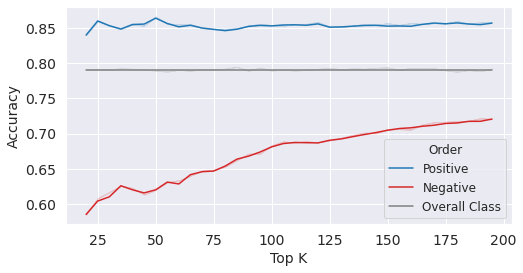

In [22]:
# load flip interventions


In [43]:
cls = 18
print(class_names[cls])
flip_interventions = torch.load(f"/mnt/cfs/home/saachij/src/failure-directions/failure_directions/cifar100_sd_{cls}.pt")

df = []
for intensity in [0.1, 0.2, 0.3]:
    load_corrects = {
        'flip': [(flip_interventions[intensity][u][0] == flip_interventions[intensity][u][1]) for u in range(len(flip_interventions[intensity]))],
        'base': [(flip_interventions[0][u][0] == flip_interventions[0][u][1]) for u in range(len(flip_interventions[0]))],
    #     'none': [(no_intervention[u][0] == no_intervention[u][1]) for u in range(5)],

    }

    mask = (test_problematic & (test_superclass == cls))
    df.append([intensity,
        np.mean([load_corrects['flip'][u][mask].float().mean().item() for u in range(5)]), 
        np.mean([load_corrects['base'][u][mask].float().mean().item() for u in range(5)]),
          test_correct[mask].mean(),
              ])
df = pd.DataFrame(df, columns=['intensity', 'Flip', 'Base', "Original"])
df

vehicles 1


,intensity,Flip,Base,Original
0,0.1,0.650,0.62,0.65
1,0.2,0.626,0.62,0.65
2,0.3,0.602,0.62,0.65


In [33]:
[load_corrects['base'][u][mask].float().mean().item() for u in range(5)]

[0.6899999976158142,
 0.6899999976158142,
 0.6299999952316284,
 0.7099999785423279,
 0.75]

,intensity,Flip,Base,Original
0,0.1,0.520,0.514,0.48
1,0.2,0.482,0.514,0.48
2,0.3,0.478,0.514,0.48


In [116]:
intensity = 0.3
load_corrects = {
    'flip': [(flip_interventions[intensity][u][0] == flip_interventions[intensity][u][1]) for u in range(len(flip_interventions[intensity]))],
    'base': [(flip_interventions[0][u][0] == flip_interventions[0][u][1]) for u in range(len(flip_interventions[0]))],
#     'none': [(no_intervention[u][0] == no_intervention[u][1]) for u in range(5)],

}
print(torch.stack(load_corrects['flip']).float().mean(), torch.stack(load_corrects['base']).float().mean())

K = 100
# for target_class in range(10):
all_dfs = []
print(cifar_label_list[target_class], base_accs[target_class], orig_accs[target_class])
for v in range(1):
    dfs = []
    for target_c in range(10):
#     for target_c in [target_class]:
        xaxis = np.arange(20, 200, 5)
        indices, caption = saved_caption_and_most_relevant_imgs[(target_c, 0, 'neg')]
        base, _ = get_cdf(load_corrects['base'][v][indices].float(), xaxis)
        flip, _ = get_cdf(load_corrects[('flip')][v][indices].float(), xaxis)
#         none, _ = get_cdf(load_corrects[('none')][v][indices].float(), xaxis)

        df = pd.DataFrame()
        df['Top K'] = xaxis
        df['Adding generic synthetic images'] = base
        df['Adding synthetic images via SVM'] = flip
#         df['No intervention'] = none

        df = df.melt('Top K', var_name='Order', value_name='Subpopulation Accuracy')
        df['Class'] = target_c
        dfs.append(df)
    combined_df = pd.concat(dfs).reset_index()
    combined_df = combined_df.groupby(['Top K', 'Order']).mean().reset_index()[['Top K', 'Order', 'Subpopulation Accuracy']]
    all_dfs.append(combined_df)

df = pd.concat(all_dfs).reset_index()
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.lineplot(data=df, x='Top K', y='Subpopulation Accuracy', hue='Order', ax=ax)
ax.set_xlabel("Top K Test Images by Caption")
plt.show()

KeyError: 0.3

In [25]:
50000*0.25/10

1250.0

In [65]:
clip_analyzer.captions['reference']

['a photo of a airplane',
 'a photo of a automobile',
 'a photo of a bird',
 'a photo of a cat',
 'a photo of a deer',
 'a photo of a dog',
 'a photo of a frog',
 'a photo of a horse',
 'a photo of a ship',
 'a photo of a truck']

In [13]:
out = torch.load("synth_model_results.pt")

In [14]:
no_intervention = out['no_intervention']
flip_interventions = out['flip_intervention']
base_intervention = out['base_intervention']

In [81]:
no_intervention

[(tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([0.9736, 0.9980, 0.9996,  ..., 0.9998, 0.9998, 0.9724])),
 (tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([0.8502, 0.9268, 0.9994,  ..., 0.9996, 0.9960, 0.9489])),
 (tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([0.7708, 0.9999, 1.0000,  ..., 0.9988, 0.9972, 0.9987])),
 (tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([0.6072, 0.9871, 0.9984,  ..., 0.9992, 0.9999, 0.9983])),
 (tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([0.8949, 0.9939, 0.9277,  ..., 0.9601, 0.8612, 0.9952]))]

In [ ]:
out = np.load("/mnt/nfs/projects/data-transfer/mturk_target_groupings/infl_values.npy")

In [ ]:
imagenet_label_list = np.array([CLASS_DICT['ImageNet'][u].split(',')[0] for u in range(1000)])